In [10]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords') #A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 
nltk.download('wordnet') #WordNet is a NLTK lexical database containing details such as synonyms, antonyms, etc.
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install contractions #A contraction is a shortened version of the spoken and written forms of a word, syllable, or word group, created by omission of internal letters and sounds. For example, not is contracted to n't, I am is contracted to I'm.
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
ERROR: Invalid requirement: '#A'


### LOADING THE DATA ( *** REMEMBER TO SAVE THE DATA SETS IN THE SAME FOLDER WITH THE NOTEBOOK)
### Note: These are twitter data, sourced from GITHUB
We only need the texts and the emotions classes for each text, so we will extract these 2 only

In [11]:
train_data = pd.read_csv('train.txt', names=['text', 'emotion'], sep=';')
val_data = pd.read_csv('val.txt', names=['text', 'emotion'], sep=';')
test_data = pd.read_csv('test.txt', names=['text', 'emotion'], sep=';')
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Data Overview (EDA)

**Check for null values in train, validation and test dataset**

In [12]:
data = {'Train Data': train_data, 'Validation Data': val_data, 'Test Data': test_data}
for temp in data:
    print(temp)
    print(data[temp].isnull().sum())
    print('*'*20)

Train Data
text       0
emotion    0
dtype: int64
********************
Validation Data
text       0
emotion    0
dtype: int64
********************
Test Data
text       0
emotion    0
dtype: int64
********************


**Below is the frequencies of each classes in Train, val and test dataset**

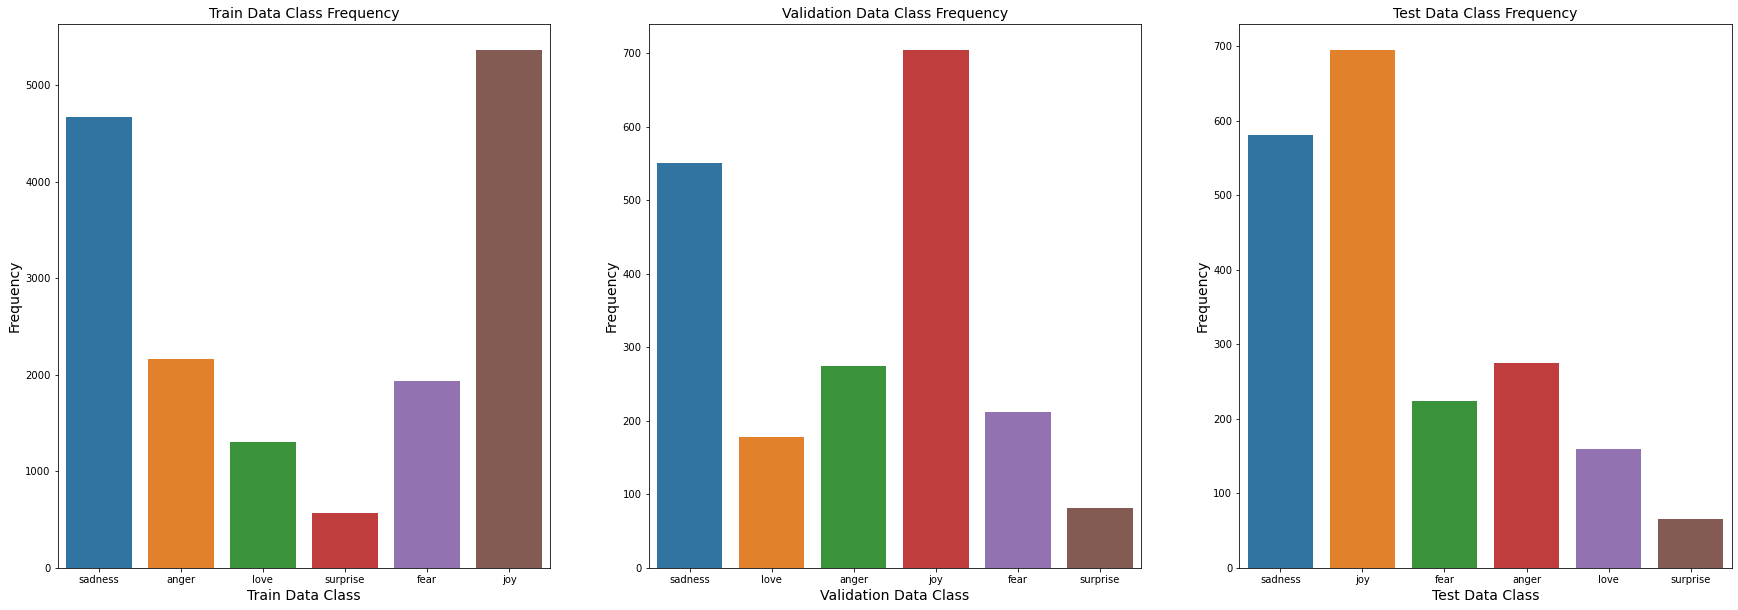

In [13]:
bar, ax = plt.subplots(1,3, figsize=(30, 10))
for index, temp in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[temp])
    ax[index].set_title(temp+' Class Frequency', size=14)
    ax[index].set_ylabel('Frequency', size=14)
    ax[index].set_xlabel(temp+' Class', size=14)

The data is skewed towards sadness and joy thus. Detection of these data might be more efficient than detection of lesser present data such as surprise.

It is evident that dataset is highly imbalanced. "Joy" class has highest frequency  and 'Surprise' have least frequency in all three datasets.

# Data Pre-Processing

**Preprocessing includes:**
1. Removing stopwords (without removing negative words)
2. Expand Contractions
3. Lemmatization

**Note:** Negative words are removed from the set of stopwords as it makes "I am not happy" to "happy" after preprocessing. In short, it can change the semantic meaning of sentence and result into wrong training.

In [14]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except', 'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()


In [15]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess(x))
val_data['text'] = val_data['text'].apply(lambda x: preprocess(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess(x))

**Note:** As class imbalanced is evident, RandomOverSampler is used to add data(repetition) to all classes except highest frequency class.

In [16]:
from imblearn.over_sampling import RandomOverSampler
random_sampler = RandomOverSampler(random_state=0)
train_x, train_y = random_sampler.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1))
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])

## Apply OneHotEncoder to transform the data  (uniformize the data to one-hot array) to feed into model

In [17]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
y_train= le.fit_transform(np.array(train['emotion']).reshape(-1, 1)).toarray()
y_test= le.fit_transform(np.array(test_data['emotion']).reshape(-1, 1)).toarray()
y_val= le.fit_transform(np.array(val_data['emotion']).reshape(-1, 1)).toarray()

# Encoding

* Tokenize the text and Add special tokens - [CLS] and [SEP]
* create input IDs
* Pad the sentences to a maximum length, to make sure sentences to have same length for preprocessing
* Create attention masks for the above PAD tokens


In [18]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [31]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus(
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True   
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [32]:
max_len = max([len(x.split()) for x in train_data['text']])
train_input_ids,train_attention_masks = roberta_encode(train, max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data, max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data, max_len)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Create Model functions, density, metrics = 'accuracy' and compile the model by using the output from the encoding function

In [21]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(6, activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [23]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 43,                                            

C:\Users\user\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Model Training

In [17]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=4,batch_size=100)

Epoch 1/4
322/322 [==============================] - 4150s 13s/step - loss: 0.5673 - accuracy: 0.7865 - val_loss: 0.2422 - val_accuracy: 0.9190
Epoch 2/4
322/322 [==============================] - 3447s 11s/step - loss: 0.1627 - accuracy: 0.9423 - val_loss: 0.2102 - val_accuracy: 0.9250
Epoch 3/4
322/322 [==============================] - 2678s 8s/step - loss: 0.1226 - accuracy: 0.9524 - val_loss: 0.1768 - val_accuracy: 0.9280
Epoch 4/4
322/322 [==============================] - 2678s 8s/step - loss: 0.1020 - accuracy: 0.9593 - val_loss: 0.1660 - val_accuracy: 0.9350


### EVALUATION OF THE TRAINED MODEL

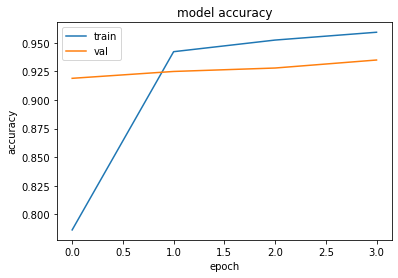

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

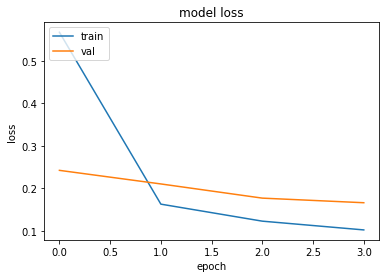

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Apply model on the test data, and check the Accuracy and F1 score

In [109]:
result = model.predict([test_input_ids,test_attention_masks])
y_prediction = np.zeros_like(result)
y_prediction[np.arange(len(result)), result.argmax(1)] = 1

63/63 [==============================] - 62s 950ms/step


**Accuracy and F1 Score of Model**

In [110]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score 
accuracy = accuracy_score(y_test, y_prediction)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_prediction, average = 'macro')
print('F1 Score :', f1)
# recall = recall_score(y_test, y_prediction)
# print('Recall:', recall)
# matrix = confusion_matrix(y_test, y_prediction)
# print('Matrix:', matrix)


Accuracy  0.9255
F1 Score : 0.8845076344621843


In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       275
           1       0.85      0.92      0.88       224
           2       0.99      0.91      0.94       695
           3       0.74      0.98      0.84       159
           4       0.99      0.95      0.97       581
           5       0.69      0.79      0.74        66

   micro avg       0.93      0.93      0.93      2000
   macro avg       0.86      0.91      0.88      2000
weighted avg       0.93      0.93      0.93      2000
 samples avg       0.93      0.93      0.93      2000



In [23]:
# Save the weight ONLY AFTER YOUR TRAINING, THEN PLEASE COMMENT OUT, BECAUSE SUBSEQUENTLY running save_weights (without retraining) will screw up the saved model
# model.save_weights('Emotion_weights.h5')
#don't run this after reopen the file


# USING THE MODEL

INSTRUCTION ON HOW TO LOAD THE MODEL AND RUN INFERENCE BELOW
1) OPEN FILES. 

2) RUN UPTIL BEFORE MODEL TRAINING ( NOTE**** DO NOT RE-TRAIN MODEL OR IT WILL TAKE 4 HOURS)

3) RUN INFERENCE BELOW AND TEST YOUR TEXTS

*** NOTE: DO NOT RUN model.save_weights because it will change the model weights and you will have to retrain 

In [24]:
def plot_result(result):
    sns.barplot(x = 'Category', y = 'Confidence',  data = result )
    plt.xlabel('Categories', size=14)
    plt.ylabel('Confidence', size=14)
    plt.title('Emotion Classification', size=16)

In [25]:
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

  
    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,

    return_attention_mask=True

    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [26]:
def inference(text_sentence, max_len):
    preprocessed_text = preprocess(text_sentence)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length = max_len)
    model = create_model(roberta_model, 43)
    model.load_weights('Emotion_weights.h5')
    result = model.predict([input_ids, attention_masks])
    result = pd.DataFrame(dict(zip(list(le.categories_[0]), [round(x*100, 2)for x in result[0]])).items(), columns = ['Category', 'Confidence'])
    plot_result(result)
    return result

1/1 [==============================] - 2s 2s/step
   Category  Confidence
0     anger       19.00
1      fear        0.44
2       joy       25.12
3      love       37.76
4   sadness       17.55
5  surprise        0.12


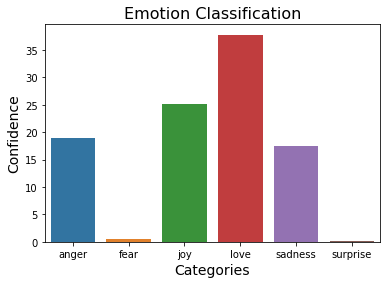

In [27]:
result = inference("i love you very much", max_len)
print(result)